In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import PowerTransformer

In [2]:
train=pd.read_csv("train.csv", parse_dates=["Scheduled Date","Delivery Date"])
test=pd.read_csv("test.csv", parse_dates=["Scheduled Date","Delivery Date"])
train.shape, test.shape

((6500, 20), (3500, 19))

In [3]:
test.sample()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location
77,fffe3300360039003100,Catherine Schlager,0.44,27.0,11.0,554163.0,Marble,2279.74,64.84,No,No,Yes,Roadways,No,Working Class,No,2016-09-27,2016-09-27,"Kaylabury, CA 93385"


In [4]:
test_id=test["Customer Id"]

In [5]:
train.sample(5)

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
5122,fffe3200390039003300,Sonia Philpot,0.31,22.0,NaN,5642.0,Brass,8.77,45.75,No,No,No,NaN,No,Working Class,NaN,2016-03-11,2016-03-09,"Aaronhaven, TX 19232",436.25
4247,fffe3500390039003200,Norma Johnson,0.35,35.0,19.0,71033.0,Bronze,94.32,66.97,No,No,No,NaN,No,Working Class,No,2018-05-19,2018-05-20,"Port Michelle, IL 10374",1509.77
5092,fffe3600340034003600,Tamara Hill,0.07,33.0,8.0,477.0,Wood,4.32,24.54,No,Yes,Yes,NaN,No,Working Class,No,2019-02-07,2019-02-11,"East Diana, UT 84865",151.53
2254,fffe3400380035003000,Matthew Turkin,0.39,17.0,8.0,566.0,NaN,6.07,20.75,No,No,Yes,Roadways,No,Working Class,NaN,2017-12-28,2017-12-28,APO AP 82136,256.95
1579,fffe3500390031003500,Tonia Sidwell,0.58,6.0,4.0,42.0,Wood,6.66,15.34,No,No,Yes,Roadways,No,Working Class,No,2016-05-24,2016-05-27,"Elizabethside, UT 53628",201.72


In [6]:
data=pd.concat((train, test), axis=0)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 3499
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Customer Id            10000 non-null  object        
 1   Artist Name            10000 non-null  object        
 2   Artist Reputation      9028 non-null   float64       
 3   Height                 9506 non-null   float64       
 4   Width                  9275 non-null   float64       
 5   Weight                 9264 non-null   float64       
 6   Material               9236 non-null   object        
 7   Price Of Sculpture     10000 non-null  float64       
 8   Base Shipping Price    10000 non-null  float64       
 9   International          10000 non-null  object        
 10  Express Shipment       10000 non-null  object        
 11  Installation Included  10000 non-null  object        
 12  Transport              8376 non-null   object        
 13  Fr

In [8]:
data.nunique()

Customer Id              10000
Artist Name               9865
Artist Reputation          101
Height                      66
Width                       42
Weight                    6320
Material                     7
Price Of Sculpture        4813
Base Shipping Price       4744
International                2
Express Shipment             2
Installation Included        2
Transport                    3
Fragile                      2
Customer Information         2
Remote Location              2
Scheduled Date            1697
Delivery Date             1699
Customer Location         9999
Cost                      6356
dtype: int64

In [9]:
data.drop(["Customer Id","Artist Name"], axis=1, inplace=True)

In [10]:
data["location"]=data["Customer Location"].str[-8:-6]
data.drop(["Customer Location"], axis=1, inplace=True)

In [11]:
data["days"]=(data["Scheduled Date"]- data["Delivery Date"]).dt.days
data.drop(["Scheduled Date","Delivery Date"], axis=1, inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 3499
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Artist Reputation      9028 non-null   float64
 1   Height                 9506 non-null   float64
 2   Width                  9275 non-null   float64
 3   Weight                 9264 non-null   float64
 4   Material               9236 non-null   object 
 5   Price Of Sculpture     10000 non-null  float64
 6   Base Shipping Price    10000 non-null  float64
 7   International          10000 non-null  object 
 8   Express Shipment       10000 non-null  object 
 9   Installation Included  10000 non-null  object 
 10  Transport              8376 non-null   object 
 11  Fragile                10000 non-null  object 
 12  Customer Information   10000 non-null  object 
 13  Remote Location        9229 non-null   object 
 14  Cost                   6500 non-null   float64
 15  loc

In [13]:
mean=np.mean(data["Artist Reputation"])
data["Artist Reputation"].fillna(mean, inplace=True)

mean=np.mean(data["Height"])
data["Height"].fillna(mean, inplace=True)
 
mean=np.mean(data["Width"])
data["Width"].fillna(mean, inplace=True)

mean=np.mean(data["Weight"])
data["Weight"].fillna(mean, inplace=True)

In [14]:
#most_freq=(data["Material"]).mode()[0]
data["Material"].fillna("New", inplace=True)

most_freq=(data["Transport"]).mode()[0]
data["Transport"].fillna("New", inplace=True)

#most_freq=(data["Transport"]).mode()[0]
data["Remote Location"].fillna("New", inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 3499
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Artist Reputation      10000 non-null  float64
 1   Height                 10000 non-null  float64
 2   Width                  10000 non-null  float64
 3   Weight                 10000 non-null  float64
 4   Material               10000 non-null  object 
 5   Price Of Sculpture     10000 non-null  float64
 6   Base Shipping Price    10000 non-null  float64
 7   International          10000 non-null  object 
 8   Express Shipment       10000 non-null  object 
 9   Installation Included  10000 non-null  object 
 10  Transport              10000 non-null  object 
 11  Fragile                10000 non-null  object 
 12  Customer Information   10000 non-null  object 
 13  Remote Location        10000 non-null  object 
 14  Cost                   6500 non-null   float64
 15  loc

In [16]:
cat_col=[]
le=LabelEncoder()
for i in data.select_dtypes(include="object").columns:
    cat_col.append(i)
    data[i]=le.fit_transform(data[i])
    
cat_col

['Material',
 'International',
 'Express Shipment',
 'Installation Included',
 'Transport',
 'Fragile',
 'Customer Information',
 'Remote Location',
 'location']

In [17]:
agg_data={
    'Artist Reputation':['sum','max','min','mean'],
    'Price Of Sculpture':['sum','max','min','mean'],
    'Base Shipping Price':['mean','max']
    
}

df = data.groupby(['Material']).agg(agg_data)

df.columns=['A_' + '_'.join(col).strip() for col in df.columns.values]
df.reset_index(inplace=True)
df.head()
data=data.merge(df,on='Material',how='left')

In [18]:
to_drop=[]
corr_matrix = data.drop(['Cost'],axis=1).corr()
# print(corr_matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper   

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)


['A_Price Of Sculpture_max', 'A_Price Of Sculpture_min', 'A_Price Of Sculpture_mean']


In [19]:
data.drop(to_drop,inplace=True,axis=1)

In [20]:
agg_data={
    'Artist Reputation':['sum','max','min','mean'],
    'Price Of Sculpture':['sum','max','min','mean'],
    'Base Shipping Price':['mean','max']
    
}

df = data.groupby(['Fragile','Customer Information']).agg(agg_data)

df.columns=['B_' + '_'.join(col).strip() for col in df.columns.values]
df.reset_index(inplace=True)

data=data.merge(df,on=['Fragile','Customer Information'],how='left')
data.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,...,B_Artist Reputation_sum,B_Artist Reputation_max,B_Artist Reputation_min,B_Artist Reputation_mean,B_Price Of Sculpture_sum,B_Price Of Sculpture_max,B_Price Of Sculpture_min,B_Price Of Sculpture_mean,B_Base Shipping Price_mean,B_Base Shipping Price_max
0,0.26,17.0,6.000000,4128.000000,1,13.91,16.27,1,1,0,...,2859.892378,1.0,0.0,0.461496,6.598958e+06,382385.67,3.0,1064.863259,38.260155,99.98
1,0.28,3.0,3.000000,61.000000,1,6.83,15.00,0,0,0,...,2859.892378,1.0,0.0,0.461496,6.598958e+06,382385.67,3.0,1064.863259,38.260155,99.98
2,0.07,8.0,5.000000,237.000000,3,4.96,21.18,0,0,0,...,545.632992,1.0,0.0,0.460839,1.865836e+06,93376.59,3.0,1575.874797,30.379569,99.45
3,0.12,9.0,9.528625,391388.296848,0,5.81,16.31,0,0,0,...,1022.922813,1.0,0.0,0.465388,2.483274e+06,231660.46,3.0,1129.788116,38.426233,99.91
4,0.15,17.0,6.000000,324.000000,0,3.18,11.94,1,1,1,...,2859.892378,1.0,0.0,0.461496,6.598958e+06,382385.67,3.0,1064.863259,38.260155,99.98


In [21]:
to_drop=[]
corr_matrix = data.drop(['Cost'],axis=1).corr()
# print(corr_matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper   

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)


['B_Price Of Sculpture_sum', 'B_Price Of Sculpture_max', 'B_Price Of Sculpture_mean']


In [22]:
data.drop(to_drop,inplace=True,axis=1)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Artist Reputation           10000 non-null  float64
 1   Height                      10000 non-null  float64
 2   Width                       10000 non-null  float64
 3   Weight                      10000 non-null  float64
 4   Material                    10000 non-null  int32  
 5   Price Of Sculpture          10000 non-null  float64
 6   Base Shipping Price         10000 non-null  float64
 7   International               10000 non-null  int32  
 8   Express Shipment            10000 non-null  int32  
 9   Installation Included       10000 non-null  int32  
 10  Transport                   10000 non-null  int32  
 11  Fragile                     10000 non-null  int32  
 12  Customer Information        10000 non-null  int32  
 13  Remote Location             1000

In [24]:
train=data[~data["Cost"].isna()]
test=data[data["Cost"].isna()].drop("Cost", axis=1)

In [25]:
train.shape, test.shape

((6500, 31), (3500, 30))

In [26]:
x=train.drop("Cost", axis=1)
y=train[["Cost"]].abs()

In [27]:
cat_features_index = [i for i,col in enumerate(x.columns) if col in cat_col]
cat_features_index

[4, 7, 8, 9, 10, 11, 12, 13, 14]

In [28]:
x_train, x_test, y_train , y_test= train_test_split(x,y, test_size=0.3, random_state=122)

In [29]:
def test_accuracy(models):
    for i in models:
        i.fit(x_train,np.log(y_train))
        pred=pd.Series(i.predict(x_test)).abs()
        print("{}:{}".format(i,mean_squared_log_error(y_test, np.exp(pred))))

In [32]:
ran=RandomForestRegressor(n_jobs=-1)
grad=GradientBoostingRegressor()
xgb=XGBRegressor()
lgb=LGBMRegressor()
cat=CatBoostRegressor(verbose=200)

In [33]:
models=[xgb, ran, lgb, grad, cat]
test_accuracy(models)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None):0.09299050116172192
RandomForestRegressor(n_jobs=-1):0.12974239931422776
LGBMRegressor():0.09291203673494093
GradientBoostingRegressor():0.13886608543780896
Learning rate set to 0.051112
0:	learn: 1.5794214	total: 145ms	remaining: 2m 24s
200:	learn: 0.2879892	total: 607ms	remaining: 2.41s
400:	learn: 0.2196253	total: 1.02s	remaining: 1.52s
600:	learn: 0.1896293	total: 1.4s	remaining: 927ms
800:	learn: 0.1691163	total: 1.8

In [34]:
reg1 = XGBRegressor()
reg1.fit(x_train,np.log(y_train),eval_set=[(x_train,np.log(y_train)),(x_test,np.log(y_test))],verbose=200)

[0]	validation_0-rmse:4.42469	validation_1-rmse:4.48412
[99]	validation_0-rmse:0.08038	validation_1-rmse:0.30529


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
ypred_xgb = pd.Series(reg1.predict(x_test)).abs()
mean_squared_log_error(y_test,np.exp(ypred_xgb))

0.09299050116172192

In [36]:
reg = LGBMRegressor()
reg.fit(x_train,np.log(y_train),eval_set=[(x_train,np.log(y_train)),(x_test, np.log(y_test))],verbose=200)

LGBMRegressor()

In [37]:
ypred_lgb = pd.Series(reg.predict(x_test)).abs()
mean_squared_log_error(y_test, np.exp(ypred_lgb))

0.09291203673494093

In [38]:
bst = CatBoostRegressor()
bst.fit(x_train,np.log(y_train),eval_set=[(x_test, np.log(y_test))], early_stopping_rounds=100,verbose=200,cat_features=cat_features_index)

Learning rate set to 0.061355
0:	learn: 1.5636267	test: 1.5943587	best: 1.5943587 (0)	total: 59.5ms	remaining: 59.5s
200:	learn: 0.2689695	test: 0.3341391	best: 0.3341391 (200)	total: 3.21s	remaining: 12.8s
400:	learn: 0.2189464	test: 0.3011283	best: 0.3011283 (400)	total: 6.36s	remaining: 9.49s
600:	learn: 0.1935458	test: 0.2905532	best: 0.2905393 (599)	total: 9.44s	remaining: 6.27s
800:	learn: 0.1749176	test: 0.2860899	best: 0.2860441 (796)	total: 12.6s	remaining: 3.13s
999:	learn: 0.1602958	test: 0.2829463	best: 0.2829358 (994)	total: 15.7s	remaining: 0us

bestTest = 0.2829358407
bestIteration = 994

Shrink model to first 995 iterations.


In [39]:
ypred_cat = pd.Series(bst.predict(x_test)).abs()
mean_squared_log_error(y_test, np.exp(ypred_cat))

0.07988038574735223

In [40]:
bst.fit(x,np.log(y), verbose=200)
prediction=pd.Series(np.exp(bst.predict(test))).abs()

Learning rate set to 0.054463
0:	learn: 1.5809827	total: 6.6ms	remaining: 6.59s
200:	learn: 0.2818571	total: 411ms	remaining: 1.63s
400:	learn: 0.2211980	total: 796ms	remaining: 1.19s
600:	learn: 0.1944307	total: 1.2s	remaining: 795ms
800:	learn: 0.1755646	total: 1.72s	remaining: 427ms
999:	learn: 0.1600744	total: 2.28s	remaining: 0us


In [41]:
pred=pd.DataFrame(prediction,columns=["Cost"])
submission=pd.concat((test_id,pred), axis=1)
submission.head()

,Customer Id,Cost
0,fffe3400310033003300,270.553321
1,fffe3600350035003400,266.511813
2,fffe3700360030003500,169.441282
3,fffe350038003600,194.820980
4,fffe3500390032003500,324.448699


In [42]:
submission.to_csv("submission.csv", index=False)

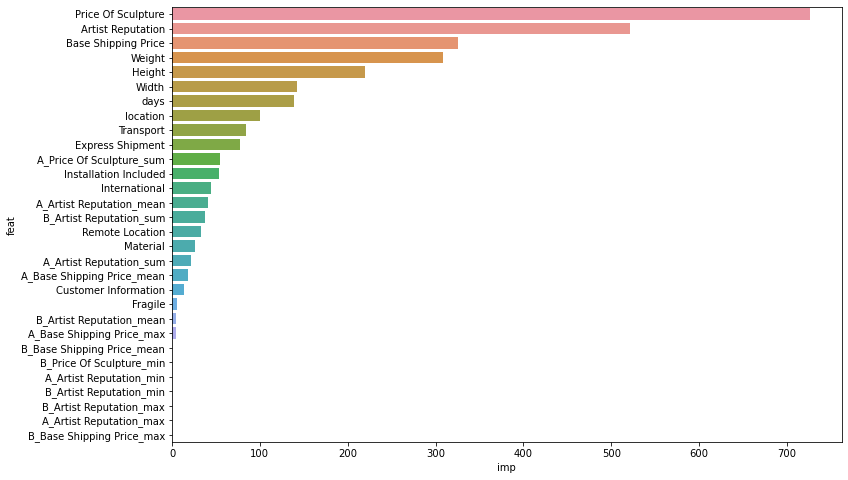

In [43]:
plt.figure(figsize=(12,8))
lgb.fit(x,np.log(y))
a=zip(x.columns,lgb.feature_importances_)
feat_imp=pd.DataFrame(a)
feat_imp.columns=["feat","imp"]
feat_imp=feat_imp.sort_values(by="imp", ascending=False)
sns.barplot(data=feat_imp, x="imp", y="feat");
#feat_imp.plot("feat","imp","barh",figsize=(12,8));

In [44]:
feat=list(feat_imp["feat"][:21])
feat

['Price Of Sculpture',
 'Artist Reputation',
 'Base Shipping Price',
 'Weight',
 'Height',
 'Width',
 'days',
 'location',
 'Transport',
 'Express Shipment',
 'A_Price Of Sculpture_sum',
 'Installation Included',
 'International',
 'A_Artist Reputation_mean',
 'B_Artist Reputation_sum',
 'Remote Location',
 'Material',
 'A_Artist Reputation_sum',
 'A_Base Shipping Price_mean',
 'Customer Information',
 'Fragile']

In [45]:
bst=XGBRegressor(max_depth=12, n_estimators=482, learning_rate=0.1,min_child_weight=15)
bst.fit(x[feat],np.log(y))
prediction=pd.Series(np.exp(bst.predict(test[feat]))).abs()

In [46]:
pred=pd.DataFrame(prediction,columns=["Cost"])
submission=pd.concat((test_id,pred), axis=1)
submission.head()

,Customer Id,Cost
0,fffe3400310033003300,231.684692
1,fffe3600350035003400,261.620148
2,fffe3700360030003500,186.253464
3,fffe350038003600,179.312103
4,fffe3500390032003500,336.324554


In [47]:
submission.to_csv("submission.csv", index=False)